In [14]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
from sklearn.metrics import mean_absolute_error

import tidalsim.modeling.extrapolation as tme

import importlib
importlib.reload(tme)

def make_arrays_equal_size(arr1, arr2):
    if len(arr1) > len(arr2):
        return arr1[:len(arr2)], arr2
    else:
        return arr1, arr2[:len(arr1)]

In [9]:
def get_run_dir(binary: str) -> Path:
    return Path.cwd().parent / "runs" / binary

interval_length = 1000
clusters = 12
run_dir = get_run_dir("aha-mont64-fb8c96bc") # TODO: Enter run_dir here
estimated_perf, true_perf = tme.analyze_tidalsim_results(run_dir, interval_length, clusters, detailed_warmup_insts=100, elf=False)

In [33]:
y_true, y_pred = make_arrays_equal_size(true_perf.ipc, estimated_perf.est_ipc)
ipc_mape = mean_absolute_error(y_true, y_pred)
print(ipc_mape)
ipc_abs_error_trace = np.abs((y_true - y_pred) / y_true)

0.04843281234950694


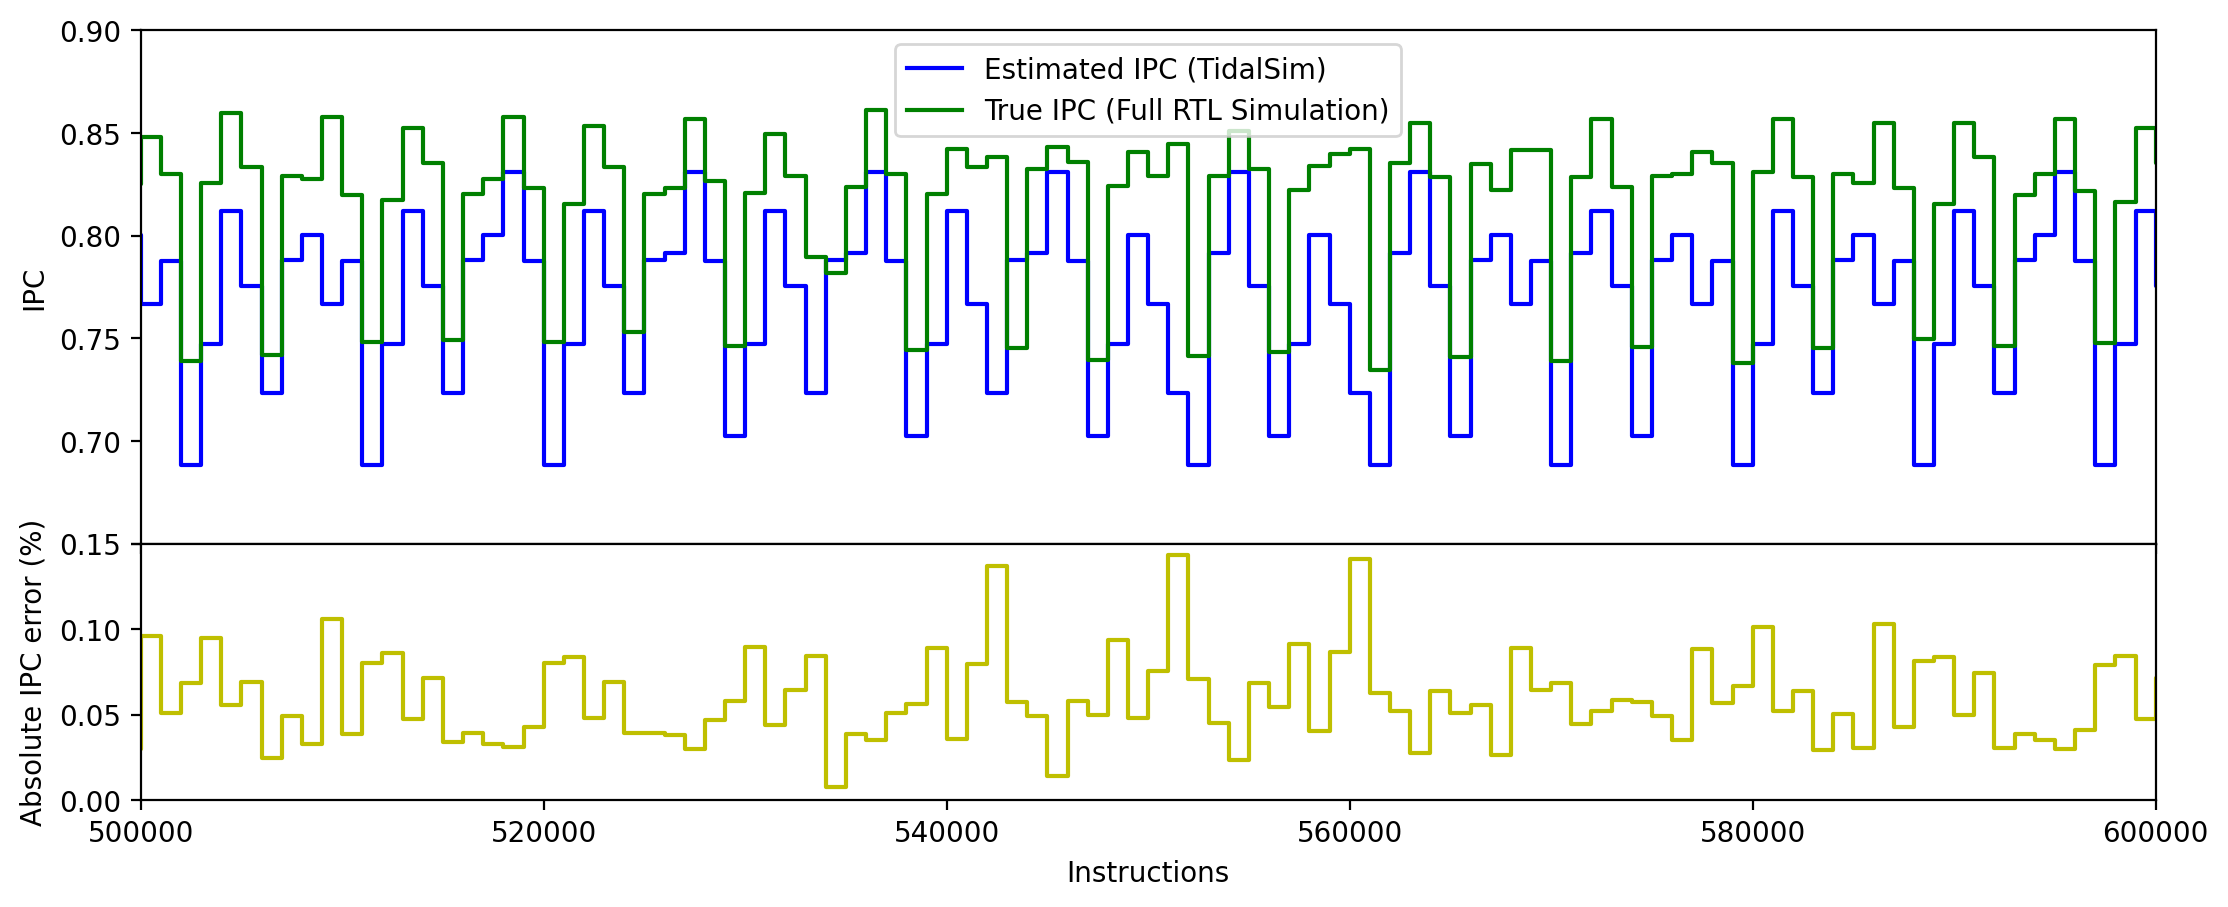

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw=dict(height_ratios=[2,1]))

p1, = ax1.step(estimated_perf.inst_count, estimated_perf.est_ipc, "b", label="Estimated IPC (TidalSim)")
p2, = ax1.step(true_perf.inst_count, true_perf.ipc, "g", label="True IPC (Full RTL Simulation)")
p3, = ax2.step(true_perf.inst_count, ipc_abs_error_trace, 'y', label="Absolute IPC error")
ax1.set_xlim([0.5e6, 0.6e6])
ax1.set_ylim([0.65, 0.9])
ax2.set_ylim([0.0, 0.15])
ax2.set_xlabel('Instructions')
ax1.set_ylabel('IPC')
ax2.set_ylabel('Absolute IPC error (%)')
ax1.legend()
# remove top-most tick label for the first subplot
yticks = ax1.yaxis.get_major_ticks()
yticks[0].label1.set_visible(False)
plt.subplots_adjust(hspace=.0)
fig.set_size_inches(13, 5)

In [6]:
estimated_perf.est_ipc

0       0.747225
1       0.800367
2       0.766681
3       0.787646
4       0.688577
          ...   
1920    0.688577
1921    0.831031
1922    0.831031
1923    0.831031
1924    0.831031
Name: est_ipc, Length: 1925, dtype: float64

In [7]:
true_perf.ipc

0       0.291036
1       0.766284
2       0.786782
3       0.795545
4       0.640615
          ...   
1916    0.821693
1917    0.856898
1918    0.834028
1919    0.741290
1920    0.491841
Name: ipc, Length: 1921, dtype: float64